# Imports 

In [20]:
#standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from env import user, password, host
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")


# Exercise I
* Create a new repository named regression-exercises in your GitHub; all of your Regression work will be housed here.
* Clone this repository within your local codeup-data-science directory.
* Create a .gitignore and make sure your list of 'files to ignore' includes your env.py file.
* Ceate a README.md file that outlines the contents and purpose of your repository.
* Add, commit, and push these two files.
* Now you can add your env.py file to this repository to access the Codeup database server.
* For these exercises, you will create wrangle.ipynb and wrangle.py files to hold necessary functions.
* As always, add, commit, and push your work often.


# Exercise II
 As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the obervations from 2017.

In these exercises, you will complete the first step toward the above goal: acquire and prepare the necessary Zillow data from the zillow database in the Codeup database server.

## 1: Acquire specifed columns from the zillow database for all 'Single Family Residential' properties.
* To acquire: `bedroomcnt`, `bathroomcnt`, `calculatedfinishedsquarefeet`, `taxvaluedollarcnt`, `yearbuilt`, `taxamount`, and `fips`


### Prepare the URL and SQL that will acquire the data

In [2]:
#create url to access DB
url = f"mysql+pymysql://{user}:{password}@{host}/zillow"

#write sql query for specified columns
sql = """ 
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
FROM properties_2017
LEFT JOIN propertylandusetype USING (propertylandusetypeid)
WHERE propertylandusedesc IN ("Single Family Residential", "Inferred Single Family Residential")
"""


### Place data in DFrame

In [3]:
# read the data in a dataFrame
# data = pd.read_sql(sql, url) # --> 3:57s process


In [4]:
# copy data into dframe to avoid having to reacquire in future
df = data.copy()

In [5]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


## 2: Using your acquired Zillow data, walk through the summarization and cleaning steps in your wrangle.ipynb file like we did above. 
* You may handle the missing values however you feel is appropriate and meaningful; 
* remember to document your process and decisions using markdown and code commenting where helpful.


### Summarizations

In [6]:
df.shape
# 2152864 observations (rows) -- 7 columns (features)

(2152864, 7)

In [7]:
# null_counts will normally NOT be displayed for very very large dFrames 
# alt method below
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    2152853 non-null  float64
 1   bathroomcnt                   2152853 non-null  float64
 2   calculatedfinishedsquarefeet  2144379 non-null  float64
 3   taxvaluedollarcnt             2152371 non-null  float64
 4   yearbuilt                     2143526 non-null  float64
 5   taxamount                     2148422 non-null  float64
 6   fips                          2152864 non-null  float64
dtypes: float64(7)
memory usage: 115.0 MB


In [8]:
# breaksdown nulls by column
df.isnull().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8485
taxvaluedollarcnt                493
yearbuilt                       9338
taxamount                       4442
fips                               0
dtype: int64

In [9]:
#may want to run this AFTER taking care of nulls, and right before visualizations
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2152853.0,3.287195,0.954757,0.00,3.0000,3.000,4.0000,25.00
bathroomcnt,2152853.0,2.230687,0.999281,0.00,2.0000,2.000,3.0000,32.00
calculatedfinishedsquarefeet,2144379.0,1862.855178,1222.125124,1.00,1257.0000,1623.000,2208.0000,952576.00
taxvaluedollarcnt,2152371.0,461896.052361,699675.940049,1.00,188170.0000,327671.000,534527.0000,98428909.00
yearbuilt,2143526.0,1960.949681,22.162196,1801.00,1949.0000,1958.000,1976.0000,2016.00
taxamount,2148422.0,5634.863752,8178.908996,1.85,2534.9725,4108.945,6414.3175,1337755.86
fips,2152864.0,6048.377330,20.433289,6037.00,6037.0000,6037.000,6059.0000,6111.00


#### Takeaways - Summarization
* calculate finished square feat, yaerbuilt, taxvaluedollarcnt, taxamount have large number of null values
* bedroomcnt and bathroocnt have very small numbers of nulls
* can think about renaming categories for legibility and to conform with convention

### Cleaning - Fixing Column names

In [36]:
# take care of column names --> no need for takeaways
df = df.rename(columns = {'bedroomcnt':'bedrooms',
                            'bathroomcnt': 'bathrooms',
                            'calculatedfinishedsquarefeet': 'area',
                            'taxvaluedollarcnt': 'tax_value',
                            'taxamount': 'tax_amount',
                            'yearbuilt': 'year_built'})

### Visualize Data (Part 1)

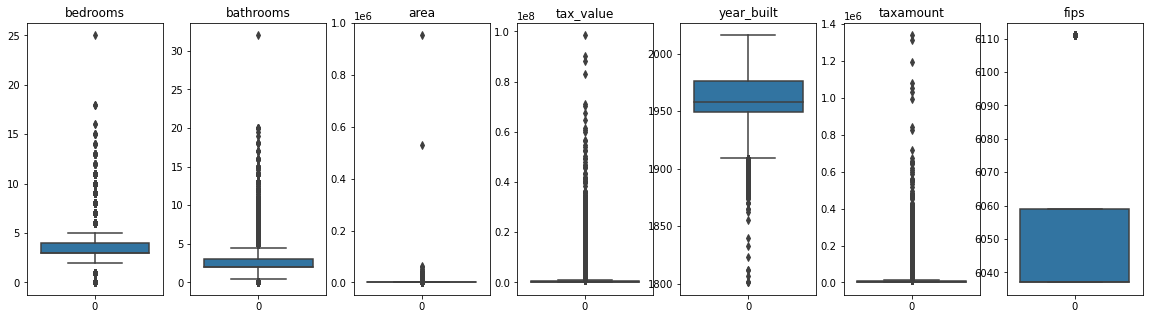

In [53]:
# build out for loop to display quick visuals of each column
plt.figure(figsize=(20,5))
i=1
for col in df.columns:
   
    plt.subplot(1, len(df.columns), i)
    df[col].hist(bins=5)
    plt.title(col)
    i += 1

plt.show()


### Takeaways
* Fips can be ignored for this visual
* Others have outliers 
    * the range of the x-axis wouldn't not need to be what it is unless there are values out there
    * can check out the plots of concern with a different type or different bin sizes

<AxesSubplot:>

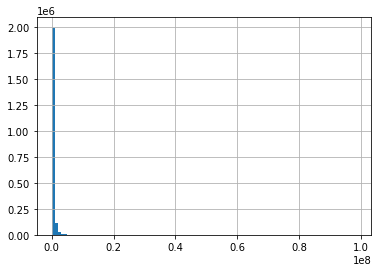

In [38]:
# tax value ---> more bins
df.tax_value.hist(bins=100)

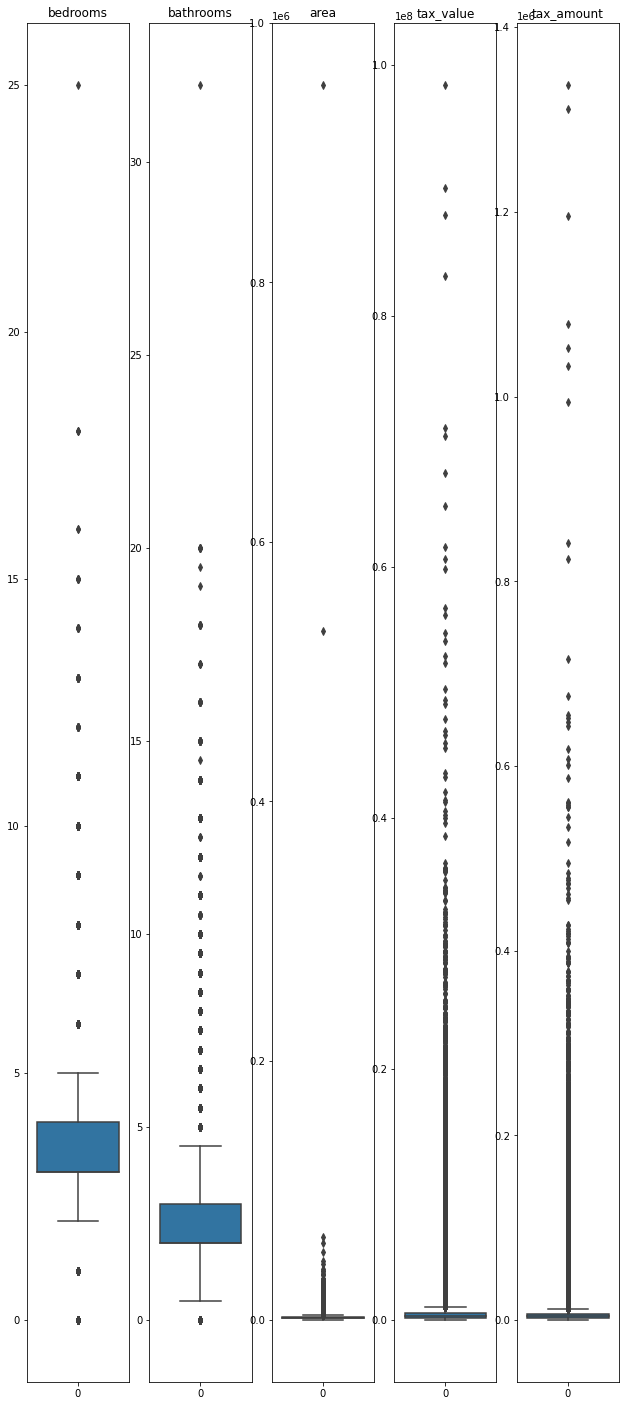

In [61]:
# check out the outliers now --> widen out the figure --> make it taller --> take them off the same plot
#plt.figure(figsize=(15,25))
#sns.boxplot(data=df.drop(columns=['fips']))

# use a loop now --> can not show fips or year built
plt.figure(figsize=(15,25))
i=1

for col in df.drop(columns=['fips', 'year_built']).columns:
   
    plt.subplot(1, len(df.columns), i)
    sns.boxplot(data=df[col])
    plt.title(col)
    i += 1

plt.show()

### Takeaways
* Area --> few outliers
* Bedrooms and Bathrooms --> comparitively few outliers and 
* tax_value and tax_amount --> extreme outliers, and in high numbers
    * check these out with the describe again --> quartiles and such

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,2152853.0,3.287195,0.954757,0.00,3.0000,3.000,4.0000,25.00
bathrooms,2152853.0,2.230687,0.999281,0.00,2.0000,2.000,3.0000,32.00
area,2144379.0,1862.855178,1222.125124,1.00,1257.0000,1623.000,2208.0000,952576.00
tax_value,2152371.0,461896.052361,699675.940049,1.00,188170.0000,327671.000,534527.0000,98428909.00
year_built,2143526.0,1960.949681,22.162196,1801.00,1949.0000,1958.000,1976.0000,2016.00
taxamount,2148422.0,5634.863752,8178.908996,1.85,2534.9725,4108.945,6414.3175,1337755.86
fips,2152864.0,6048.377330,20.433289,6037.00,6037.0000,6037.000,6059.0000,6111.00


### Handle Outliers 

In [63]:

# function for removing outliers
def remove_outliers(df, k, col_list):
    """ 
    remove outliers from a list of columns in a dataframe and return that dataframe
    """

    # total number of observations
    num_obs = df.shape[0]
        
    # Create a column that will label our rows as containing an outlier. sets default value
    df['outlier'] = False

    # loop through the columns provided to find appropriate values and labels
    for col in col_list:

        # find quartiles
        q1, q3 = df[col].quantile([.25, .75])  
        
       # get interquartile range
        iqr = q3 - q1

       # find upper/lower bounds 
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label as needed. 
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    # set dataframe to dataframe w/o the outliers
    df = df[df.outlier == False]

    # drop the outlier column from the dataFrame. no longer needed
    df.drop(columns=['outlier'], inplace=True)

    # print out number of removed observations
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
        
    return df

In [64]:
#use the above function --> 1.5*IQR is considered fairly restrictive 
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount'])
df

Number of observations removed: 239823


,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
...,...,...,...,...,...,...,...
2152854,4.0,2.0,1987.0,259913.0,1955.0,3175.66,6059.0
2152856,3.0,2.5,1809.0,405547.0,2012.0,4181.10,6059.0
2152860,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0
2152862,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0


### Visualize Data (Part 2)

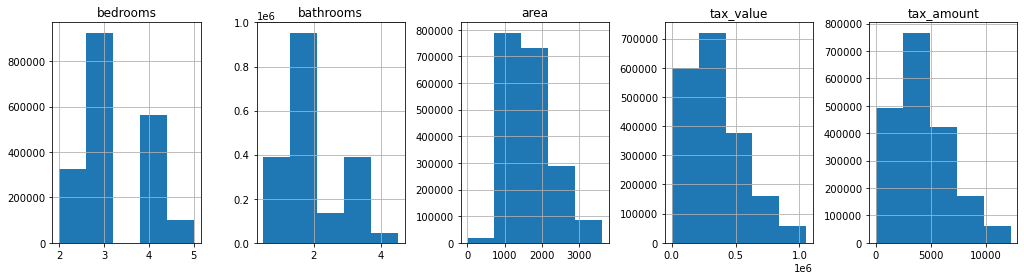

In [69]:
# build out for loop to display quick visuals of each column
plt.figure(figsize=(20,4))
i=1
for col in df.drop(columns=['fips', 'year_built']).columns:
   
    plt.subplot(1, len(df.columns), i)
    df[col].hist(bins=5)
    plt.title(col)
    plt.ticklabel_format(useOffset=False)
    plt.tight_layout()
    i += 1

plt.show()


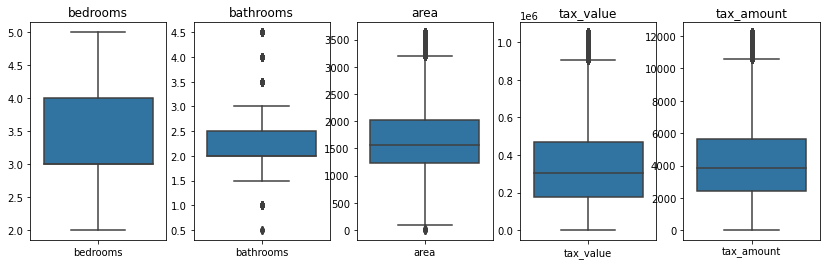

In [74]:
# boxplot 
plt.figure(figsize=(20,4))
i=1

for col in df.drop(columns=['fips', 'year_built']).columns:
   
    plt.subplot(1, len(df.columns), i)
    sns.boxplot(data=df[[col]])
    plt.title(col)
    i += 1

plt.show()

### Takeaways
* Bed/Bath not normally distributed
* Others more normal but still displaying skew
* Less outliers, but much much closer to than before. okay to leave in

### Nulls

In [75]:
# breaksdown nulls by column --> Still a decent amount
df.isnull().sum()

bedrooms        11
bathrooms       11
area           150
tax_value       99
year_built    1015
tax_amount    2022
fips             0
dtype: int64

In [81]:
# use descreibe again to check mean/median values
# df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,1913030.0,3.227959,0.787743,2.00,3.00,3.00,4.00,5.00
bathrooms,1913030.0,2.079096,0.727472,0.50,2.00,2.00,2.50,4.50
area,1912891.0,1682.923848,595.440214,1.00,1239.00,1563.00,2026.00,3634.00
tax_value,1912942.0,342387.948874,216177.349169,1.00,177517.25,303639.50,468104.00,1054000.00
year_built,1912026.0,1959.790942,20.841412,1801.00,1949.00,1957.00,1973.00,2016.00
tax_amount,1911019.0,4244.886171,2457.314734,16.48,2412.32,3830.82,5672.03,12233.33
fips,1913041.0,6048.376655,20.538860,6037.00,6037.00,6037.00,6059.00,6111.00


In [88]:
# mode for each
for col in df.drop(columns=['fips']).columns:
    print(f'{col} mode is {df[col].value_counts().head(1)}')
    print('\n')

bedrooms mode is 3.0    924083
Name: bedrooms, dtype: int64


bathrooms mode is 2.0    921681
Name: bathrooms, dtype: int64


area mode is 1200.0    5113
Name: area, dtype: int64


tax_value mode is 450000.0    809
Name: tax_value, dtype: int64


year_built mode is 1955.0    81346
Name: year_built, dtype: int64


tax_amount mode is 345.72    165
Name: tax_amount, dtype: int64




### Takeaways for Nulls
* beds, baths, area, tax_value, tax_amount - use mean to impute
* year_built - use mode to impute because we are going to make categorical 
* we will take care of imputation with a loop after we split the data


### Clean - Categories

In [89]:
# change data types for fips and year_built. 
df.fips = df.fips.astype(object)
df.year_built = df.year_built.astype(object)

### Train Test Split Impute

In [90]:
#train_test_split
train_validate, test = train_test_split(df, test_size=.2, random_state=514)
train, validate = train_test_split(train_validate, test_size=.3, random_state=514)

In [92]:
# loop throught continous columsn and impute with median
for col in df.drop(columns=['year_built', 'fips']).columns:
    imputer = SimpleImputer(strategy='median')

    imputer.fit(train[[col]])

    train[[col]] = imputer.transform(train[[col]])
    validate[[col]] = imputer.transform(validate[[col]])
    test[[col]] = imputer.transform(test[[col]])

In [94]:
#create imputer for cat types 
imputer_cat = SimpleImputer(strategy='most_frequent')

#fit both imputers to train set
imputer_cat.fit(train[['year_built']])

train[['year_built']] = imputer_cat.transform(train[['year_built']])
validate[['year_built']] = imputer_cat.transform(validate[['year_built']])
test[['year_built']] = imputer_cat.transform(test[['year_built']])

In [96]:
validate.isnull().sum()

bedrooms      0
bathrooms     0
area          0
tax_value     0
year_built    0
tax_amount    0
fips          0
dtype: int64

### Takeaways 
* Not very much to take away


## 3 - Store all of the necessary functions to automate your process from acquiring the data to returning a cleaned dataframe with no missing values in your wrangle.py file. Name your final function wrangle_zillow.

In [99]:
#### Acquire
def acquire_zillow():
    #create url to access DB
    url = f"mysql+pymysql://{user}:{password}@{host}/zillow"

    #write sql query for specified columns
    sql = """ 
    SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips
    FROM properties_2017
    LEFT JOIN propertylandusetype USING (propertylandusetypeid)
    WHERE propertylandusedesc IN ("Single Family Residential", "Inferred Single Family Residential")
    """

    #read the data in a dataFrame
    df = pd.read_sql(sql, url)

    # take care of column names --> no need for takeaways
    df = df.rename(columns = {'bedroomcnt':'bedrooms',
                                'bathroomcnt': 'bathrooms',
                                'calculatedfinishedsquarefeet': 'area',
                                'taxvaluedollarcnt': 'tax_value',
                                'taxamount': 'tax_amount',
                                'yearbuilt': 'year_built'})
    return df

#### Prepare (remove outliers, do some visualizations, and train/test/impute)

def remove_outliers(df, k, col_list):
    """ 
    Purpose
        Remove outliers from a list of columns in a dataframe and return that dataframe
    
    Parameters
        df: a dataframe containing zillow real estate data
        k: factor to multiple IQR
        col_list: a list of dataframe columns to work on 

    Returns
        df: a dataframe with the desired adjustments
    """

    # total number of observations
    num_obs = df.shape[0]
        
    # Create a column that will label our rows as containing an outlier. sets default value
    df['outlier'] = False

    # loop through the columns provided to find appropriate values and labels
    for col in col_list:

        # find quartiles
        q1, q3 = df[col].quantile([.25, .75])  
        
       # get interquartile range
        iqr = q3 - q1

       # find upper/lower bounds 
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label as needed. 
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    # set dataframe to dataframe w/o the outliers
    df = df[df.outlier == False]

    # drop the outlier column from the dataFrame. no longer needed
    df.drop(columns=['outlier'], inplace=True)

    # print out number of removed observations
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
        
    return df

def make_hist(df):
    plt.figure(figsize=(20,4))
    i=1
    for col in df.drop(columns=['fips', 'year_built']).columns:

        plt.subplot(1, len(df.columns), i)
        df[col].hist(bins=5)
        plt.title(col)
        plt.ticklabel_format(useOffset=False)
        plt.tight_layout()
        i += 1

    plt.show()

def make_box(df):
    # boxplot 
    plt.figure(figsize=(20,4))
    i=1

    for col in df.drop(columns=['fips', 'year_built']).columns:
    
        plt.subplot(1, len(df.columns), i)
        sns.boxplot(data=df[[col]])
        plt.title(col)
        i += 1

    plt.show()

# prep function to bring it together
def prep_zillow(df):
    """
    Purpose
        To return dataset for exploration

    Parameters
        df: dataframe to perform desired operations on

    Returns
        train, validate, and test datasets
    """
    #remove outliers
    df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount'])

    # view distributions with histogram and boxplots
    make_hist(df)
    make_box(df)

    # change data types for fips and year_built. 
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)

    #train_test_split
    train_validate, test = train_test_split(df, test_size=.2, random_state=514)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=514)

    # loop throught continous columsn and impute with median
    for col in df.drop(columns=['year_built', 'fips']).columns:
        imputer = SimpleImputer(strategy='median')

        imputer.fit(train[[col]])

        train[[col]] = imputer.transform(train[[col]])
        validate[[col]] = imputer.transform(validate[[col]])
        test[[col]] = imputer.transform(test[[col]])

    #create imputer for cat types 
    imputer_cat = SimpleImputer(strategy='most_frequent')

    #fit both imputers to train set
    imputer_cat.fit(train[['year_built']])

    train[['year_built']] = imputer_cat.transform(train[['year_built']])
    validate[['year_built']] = imputer_cat.transform(validate[['year_built']])
    test[['year_built']] = imputer_cat.transform(test[['year_built']])

    return train, validate, test

#### Wrangle

def wrangle_zillow():
    """ 
    Purpose
        Acquire and prepare data from Zillow data set for exploration
    
    Parameters
        None
    
    Returns 
        Cleaned and prepared train, validate, and test subsets of data for exploration and modeling
    """
    train, validate, test = prep_zillow(acquire_zillow())
    return train, validate, test

Number of observations removed: 239823


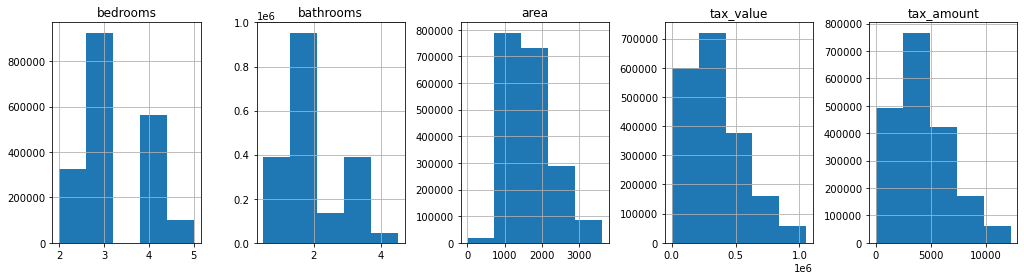

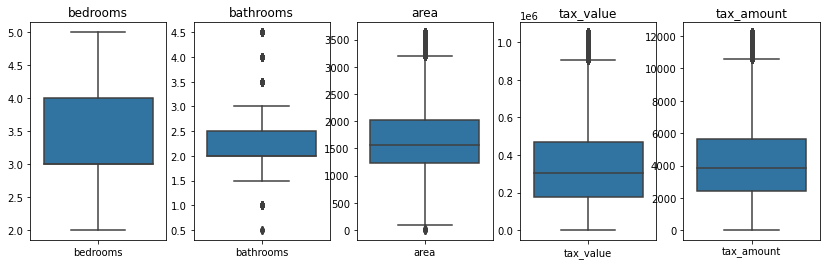

In [100]:
train, validate, test = wrangle_zillow()